In [2]:
import torch
from torch import nn
import torchvision
from torchvision import datasets
from torchvision.transforms import ToTensor
import matplotlib.pyplot as plt

In [5]:
train_data = datasets.MNIST(
    root="data",
    train=True,
    download=True,
    transform=ToTensor()
)
test_data = datasets.MNIST(
    root="data",
    train=False,
    download=True,
    transform=ToTensor()
)

Failed to download (trying next):
HTTP Error 403: Forbidden



100%|██████████| 9912422/9912422 [00:12<00:00, 807990.39it/s] 


Extracting data/MNIST/raw/train-images-idx3-ubyte.gz to data/MNIST/raw

Failed to download (trying next):
HTTP Error 403: Forbidden



100%|██████████| 28881/28881 [00:00<00:00, 223311.36it/s]


Extracting data/MNIST/raw/train-labels-idx1-ubyte.gz to data/MNIST/raw

Failed to download (trying next):
HTTP Error 403: Forbidden



100%|██████████| 1648877/1648877 [00:01<00:00, 1112799.58it/s]


Extracting data/MNIST/raw/t10k-images-idx3-ubyte.gz to data/MNIST/raw

Failed to download (trying next):
HTTP Error 403: Forbidden



100%|██████████| 4542/4542 [00:00<00:00, 6080602.86it/s]

Extracting data/MNIST/raw/t10k-labels-idx1-ubyte.gz to data/MNIST/raw


In [6]:
class_names = train_data.classes
class_names

['0 - zero',
 '1 - one',
 '2 - two',
 '3 - three',
 '4 - four',
 '5 - five',
 '6 - six',
 '7 - seven',
 '8 - eight',
 '9 - nine']

torch.Size([1, 28, 28])

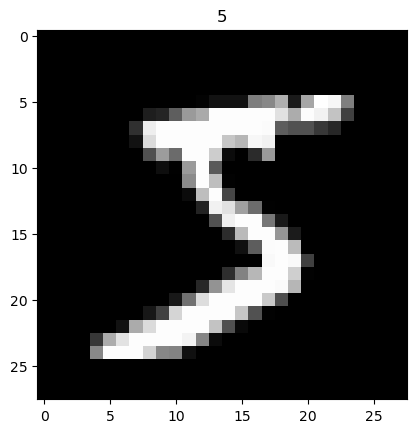

In [23]:
image, label = train_data[0]
plt.imshow(image.squeeze(), cmap="gray")
plt.title(label)
image.shape

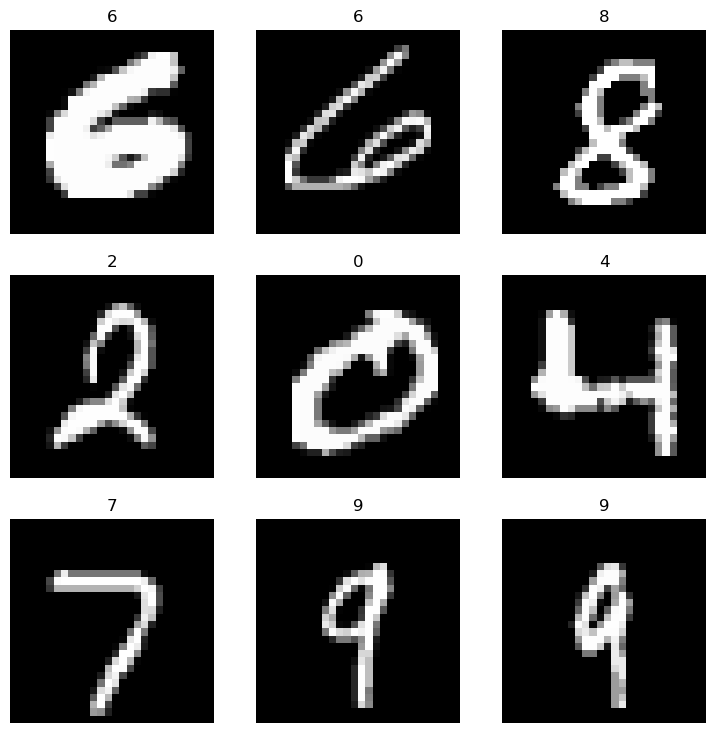

In [18]:
torch.manual_seed(42)

fig = plt.figure(figsize=(9, 9))
rows, cols = 3, 3
for i in range(1, 10):
    random_idx = torch.randint(0, len(train_data), size=[1]).item()
    img, label = train_data[random_idx]
    fig.add_subplot(rows, cols, i)
    plt.imshow(img.squeeze(), cmap="gray")
    plt.title(label)
    plt.axis(False)

In [19]:
from torch.utils.data import DataLoader

train_dataloader = DataLoader(train_data, batch_size=32, shuffle=True)
test_dataloader = DataLoader(test_data, batch_size=32, shuffle=False)

print(f"Dataloaders: {train_dataloader, test_dataloader}") 
print(f"Length of train dataloader: {len(train_dataloader)} batches of {32}")
print(f"Length of test dataloader: {len(test_dataloader)} batches of {32}")

Dataloaders: (<torch.utils.data.dataloader.DataLoader object at 0x73168fd16b90>, <torch.utils.data.dataloader.DataLoader object at 0x73168fd16b60>)
Length of train dataloader: 1875 batches of 32
Length of test dataloader: 313 batches of 32


In [22]:
class CNNModel(nn.Module):
    def __init__(self, input_shape:int, hidden_units:int, output_shape:int):
        super().__init__()
        self.block1 = nn.Sequential(
            nn.Conv2d(in_channels=input_shape, out_channels=hidden_units, kernel_size=3, padding=1, stride=1),
            nn.ReLU(),
            nn.Conv2d(in_channels=hidden_units, out_channels=hidden_units, kernel_size=3, padding=1, stride=1),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2, stride=2)
        )
        self.block2 = nn.Sequential(
            nn.Conv2d(in_channels=hidden_units, out_channels=hidden_units, kernel_size=3, padding=1),
            nn.ReLU(),
            nn.Conv2d(in_channels=hidden_units, out_channels=hidden_units, kernel_size=3, padding=1),
            nn.ReLU(),
            nn.MaxPool2d(kernel_size=2)
        )
        self.classifier = nn.Sequential(
            nn.Flatten(),
            nn.Linear(in_features=hidden_units*7*7, out_features=output_shape)
        )
        
    def forward(self, x):
        return self.classifier(self.block2(self.block1(x)))

In [26]:
model = CNNModel(1, 10, len(class_names))
model

CNNModel(
  (block1): Sequential(
    (0): Conv2d(1, 10, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU()
    (2): Conv2d(10, 10, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (3): ReLU()
    (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (block2): Sequential(
    (0): Conv2d(10, 10, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU()
    (2): Conv2d(10, 10, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (3): ReLU()
    (4): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (classifier): Sequential(
    (0): Flatten(start_dim=1, end_dim=-1)
    (1): Linear(in_features=490, out_features=10, bias=True)
  )
)

In [29]:
device = "cuda" if torch.cuda.is_available() else "cpu"
device

'cpu'

In [30]:
loss_fn = nn.CrossEntropyLoss()
optimizer = torch.optim.SGD(params=model.parameters(), lr = 0.01)

In [28]:
def train_step(model: torch.nn.Module,
               data_loader: torch.utils.data.DataLoader,
               loss_fn: torch.nn.Module,
               optimizer: torch.optim.Optimizer,
               accuracy_fn,
               device: torch.device = device):
    train_loss, train_acc = 0, 0
    model.to(device)
    model.train()
    for batch, (X, y) in enumerate(data_loader):
        X, y = X.to(device), y.to(device)
        
        y_pred = model(X)
        loss = loss_fn(y_pred, y)
        train_loss += loss
        train_acc += accuracy_fn(y, y_pred.argmax(dim=1))
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
    train_loss /= len(data_loader)
    train_acc /= len(data_loader)
    
    print(f"Train loss: {train_loss:.5f} | Train accuracy: {train_acc:.2f}%")

def test_step(data_loader: torch.utils.data.DataLoader,
              model: torch.nn.Module,
              loss_fn: torch.nn.Module,
              accuracy_fn,
              device: torch.device = device):
    
     test_loss, test_acc = 0, 0
     model.to(device)
     model.eval()
     with torch.inference_mode():
         for X, y in data_loader:
             test_preds = model(X)
             test_loss += loss_fn(test_preds, y)
             test_acc += accuracy_fn(y, test_preds.argmax(dim=1))
        
         test_loss /= len(data_loader)
         test_acc /= len(data_loader)
     print(f"Test loss: {test_loss:.5f} | Test accuracy: {test_acc:.2f}%\n")

In [31]:
from helper_functions import accuracy_fn
torch.manual_seed(42)

epochs = 3
for epoch in range(epochs):
    print(f"Epoch : {epoch}")
    train_step(data_loader=train_dataloader, model=model, optimizer=optimizer, loss_fn=loss_fn, accuracy_fn=accuracy_fn)
    test_step(data_loader=test_dataloader, model=model, loss_fn=loss_fn, accuracy_fn=accuracy_fn)
        

Epoch : 0
Train loss: 1.33003 | Train accuracy: 53.17%
Test loss: 0.25577 | Test accuracy: 91.90%

Epoch : 1
Train loss: 0.17916 | Train accuracy: 94.48%
Test loss: 0.10281 | Test accuracy: 96.82%

Epoch : 2
Train loss: 0.11057 | Train accuracy: 96.63%
Test loss: 0.08693 | Test accuracy: 97.24%


In [32]:
def make_predictions(model: torch.nn.Module, data:list, device: torch.device = device):
    test_preds = []
    model.eval()
    with torch.inference_mode():
        for sample in data:
            sample = torch.unsqueeze(sample, dim=0).to(device)
            pred_logit = model(sample)
            pred_prob = torch.softmax(pred_logit.squeeze(), dim=0) 
            test_preds.append(pred_prob.cpu())
            
    return torch.stack(test_preds)

In [33]:
import random
random.seed(42)
test_samples =[]
test_labels = []
for sample, label in random.sample(list(test_data), k=9):
    test_samples.append(sample)
    test_labels.append(label)

In [34]:
pred_probs = make_predictions(model, test_samples)
pred_classes = pred_probs.argmax(dim=1)
pred_classes

tensor([2, 1, 2, 4, 6, 6, 4, 9, 1])

In [35]:
test_labels, pred_classes

([2, 1, 2, 4, 6, 6, 4, 9, 1], tensor([2, 1, 2, 4, 6, 6, 4, 9, 1]))

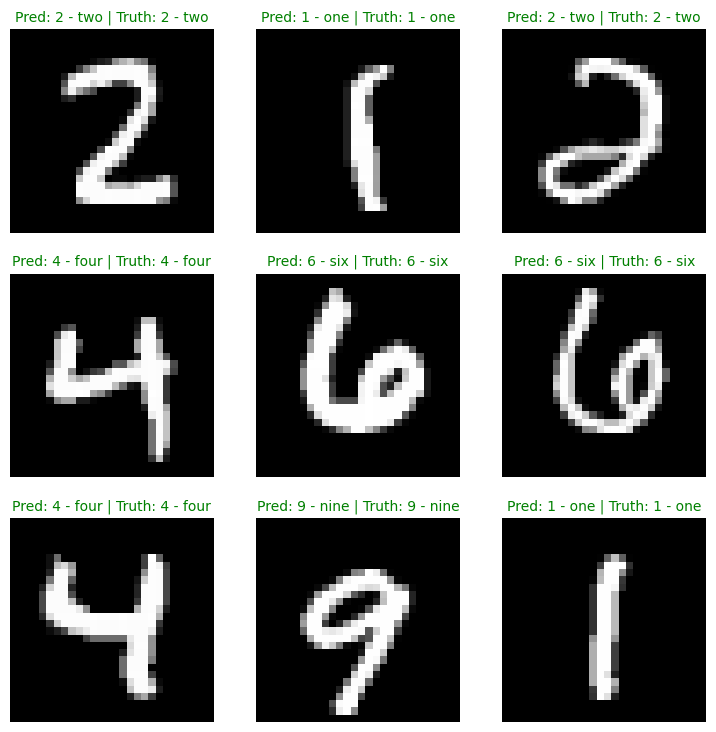

In [37]:
plt.figure(figsize=(9, 9))

for i in range(rows*cols):
    plt.subplot(rows, cols, i+1)
    plt.imshow(test_samples[i].squeeze(), cmap="gray")
    plt.title(test_labels[i])
    
    pred_label = class_names[pred_classes[i]]
    truth_label = class_names[test_labels[i]]
    
    title_text = f"Pred: {pred_label} | Truth: {truth_label}"
    if pred_label == truth_label:
      plt.title(title_text, fontsize=10, c="g")
    else:
      plt.title(title_text, fontsize=10, c="r")
    
    plt.axis(False)
    

In [38]:
import mlxtend 
from torchmetrics import ConfusionMatrix
from mlxtend.plotting import plot_confusion_matrix

/usr/lib/python3/dist-packages/scipy/__init__.py:146: UserWarning: A NumPy version >=1.17.3 and <1.25.0 is required for this version of SciPy (detected version 1.26.4
  warnings.warn(f"A NumPy version >={np_minversion} and <{np_maxversion}"


In [41]:
y_preds = []
model.eval()
with torch.inference_mode():
  for X, y in test_dataloader:
    X, y = X.to(device), y.to(device)
    y_logit = model(X)
    y_pred = torch.softmax(y_logit, dim=1).argmax(dim=1) 
    y_preds.append(y_pred.cpu())
y_pred_tensor = torch.cat(y_preds)

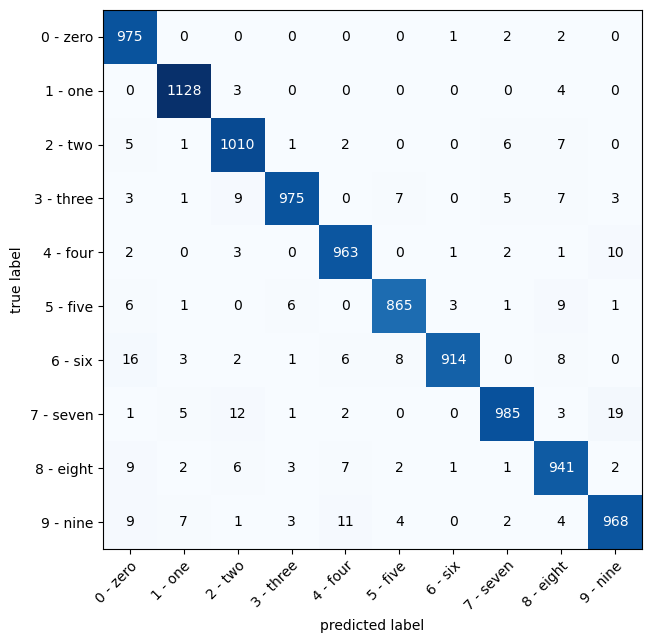

In [42]:
confmat = ConfusionMatrix(num_classes=len(class_names), task="multiclass")
confmat_tensor = confmat(preds=y_pred_tensor,
                         target=test_data.targets)

fig, ax = plot_confusion_matrix(
    conf_mat=confmat_tensor.numpy(),
    class_names=class_names,
    figsize=(10, 7)
)